# Импорт библиотек и настройка

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torchvision.transforms.v2 import RandomRotation, RandomPhotometricDistort, \
RandomHorizontalFlip, RandomVerticalFlip
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

import warnings
warnings.filterwarnings('ignore')

# Определяем устройство (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

# Если используется GPU, показываем информацию
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Используется устройство: cpu


In [21]:
import os
print("Текущая директория:", os.getcwd())

Текущая директория: /Users/vitaliy/pill_classifier


# Анализ датасета ogyeiv2:  pill_classifier/dataset/ogyeiv2

не понимает розовый и оттенки розового

In [22]:
from collections import Counter

def analyze_dataset_detailed(base_path):
    """Детальный анализ структуры датасета"""
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')
    
    # Проверяем существование путей
    if not os.path.exists(train_path):
        print(f"❌ Путь {train_path} не существует!")
        return []
    
    # Получаем список классов - только директории!
    classes = sorted([cls for cls in os.listdir(train_path) 
                     if os.path.isdir(os.path.join(train_path, cls))])
    
    print(f"📊 ДЕТАЛЬНЫЙ АНАЛИЗ ДАТАСЕТА")
    print(f"📍 Путь: {base_path}")
    print(f"🎯 Найдено классов: {len(classes)}")
    print(f"📂 Классы: {classes[:5]}...")  # Показываем первые 5
    
    train_counts = []
    test_counts = []
    all_image_extensions = set()
    
    print("\n📈 СТАТИСТИКА ПО КЛАССАМ:")
    print("-" * 50)
    
    for cls in classes:
        train_class_path = os.path.join(train_path, cls)
        test_class_path = os.path.join(test_path, cls)
        
        # Считаем изображения в train
        train_images = []
        if os.path.exists(train_class_path):
            train_images = [f for f in os.listdir(train_class_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            # Собираем расширения файлов
            for img in train_images:
                ext = os.path.splitext(img)[1].lower()
                all_image_extensions.add(ext)
        
        # Считаем изображения в test
        test_images = []
        if os.path.exists(test_class_path):
            test_images = [f for f in os.listdir(test_class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        
        train_count = len(train_images)
        test_count = len(test_images)
        
        train_counts.append(train_count)
        test_counts.append(test_count)
        
        # Выводим статистику для каждого класса
        if train_count > 0 or test_count > 0:
            print(f"  {cls:<30} | Train: {train_count:>3} | Test: {test_count:>3}")
    
    # Общая статистика
    total_train = sum(train_counts)
    total_test = sum(test_counts)
    total_images = total_train + total_test
    
    print("-" * 50)
    print(f"📋 ОБЩАЯ СТАТИСТИКА:")
    print(f"   Всего изображений: {total_images}")
    print(f"   Train: {total_train} ({total_train/total_images*100:.1f}%)")
    print(f"   Test: {total_test} ({total_test/total_images*100:.1f}%)")
    print(f"   Среднее на класс в train: {total_train/len(classes):.1f}")
    print(f"   Среднее на класс в test: {total_test/len(classes):.1f}")
    print(f"   Форматы изображений: {', '.join(sorted(all_image_extensions))}")
    
    # Статистика по распределению
    print(f"\n📊 РАСПРЕДЕЛЕНИЕ:")
    print(f"   Min изображений в классе (train): {min(train_counts)}")
    print(f"   Max изображений в классе (train): {max(train_counts)}")
    print(f"   Min изображений в классе (test): {min(test_counts)}")
    print(f"   Max изображений в классе (test): {max(test_counts)}")
    
    return classes

# Запускаем детальный анализ
classes = analyze_dataset_detailed('./dataset/ogyeiv2')
num_classes = len(classes)

📊 ДЕТАЛЬНЫЙ АНАЛИЗ ДАТАСЕТА
📍 Путь: ./dataset/ogyeiv2
🎯 Найдено классов: 84
📂 Классы: ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg']...

📈 СТАТИСТИКА ПО КЛАССАМ:
--------------------------------------------------
  acc_long_600_mg                | Train:  28 | Test:   6
  advil_ultra_forte              | Train:  28 | Test:   6
  akineton_2_mg                  | Train:  28 | Test:   6
  algoflex_forte_dolo_400_mg     | Train:  28 | Test:   6
  algoflex_rapid_400_mg          | Train:  28 | Test:   6
  algopyrin_500_mg               | Train:  28 | Test:   6
  ambroxol_egis_30_mg            | Train:  28 | Test:   6
  apranax_550_mg                 | Train:  28 | Test:   6
  aspirin_ultra_500_mg           | Train:  28 | Test:   6
  atoris_20_mg                   | Train:  28 | Test:   6
  atorvastatin_teva_20_mg        | Train:  28 | Test:   6
  betaloc_50_mg                  | Train:  28 | Test:   6
  bila_git               

# Этап 1. Загрузка и предобработка данных

## Функция предобработки изображения из датасета (detect_and_crop_pill): детекция таблеки, кроп и ресайз (224,224), частичное востановление фона - все операции с целью минимизации потерь признаков оригинального изображения при ресайзе

ПРИМЕР:


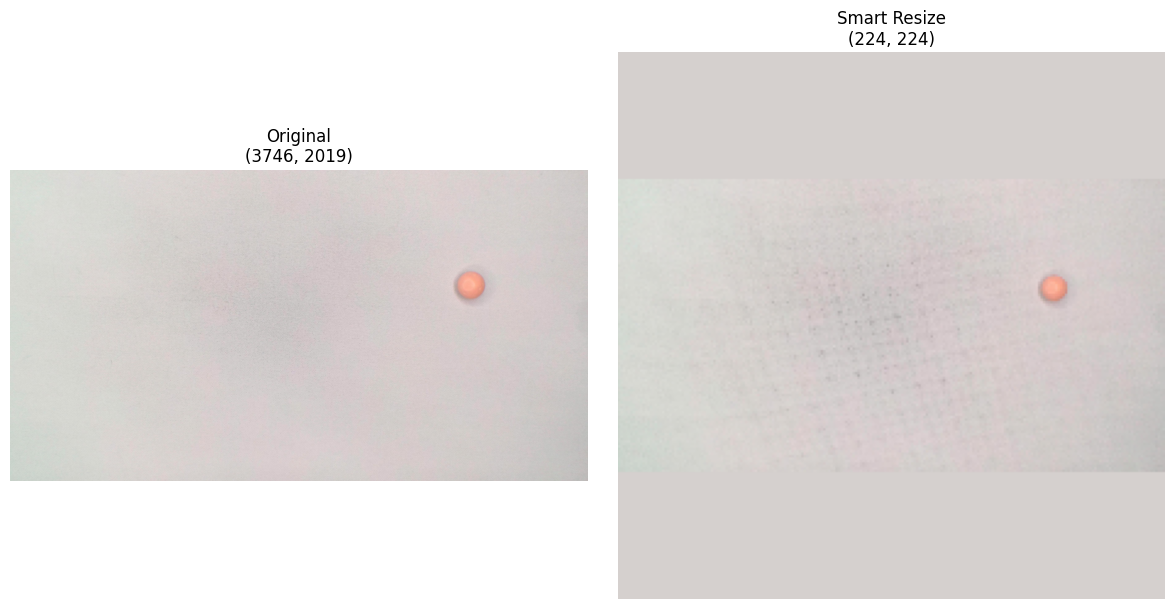

In [23]:

def detect_and_crop_pill(image_path, output_size=224):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Ошибка загрузки файла: {image_path}")
        return None
        
    original = image.copy()
    
    # Конвертируем в разные цветовые пространства
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Метод 1: Детекция по цвету (для розовой таблетки)
    # Диапазон розового цвета в HSV
    lower_pink = np.array([140, 50, 50])
    upper_pink = np.array([170, 255, 255])
    pink_mask = cv2.inRange(hsv, lower_pink, upper_pink)
    
    # Метод 2: Адаптивный порог для контраста
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 11, 2)
    
    # Метод 3: Детекция краев с разными параметрами
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 30, 100)
    
    # Комбинируем маски
    combined_mask = cv2.bitwise_or(pink_mask, adaptive_thresh)
    combined_mask = cv2.bitwise_or(combined_mask, edges)
    
    # Морфологические операции для улучшения маски
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    
    # Находим контуры на комбинированной маски
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Фильтруем контуры по площади и форме
        valid_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            # Фильтр по минимальной площади (1% от изображения)
            if area < (image.shape[0] * image.shape[1]) * 0.01:
                continue
                
            # Проверяем форму (эллипс/круг)
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                # Эллипсы и круги имеют circularity ~0.7-1.0
                if 0.5 < circularity < 1.2:
                    valid_contours.append(contour)
        
        if valid_contours:
            # Берем самый большой валидный контур
            largest_contour = max(valid_contours, key=cv2.contourArea)
            
            # Используем минимальную охватывающую окружность для эллипсов
            (center_x, center_y), radius = cv2.minEnclosingCircle(largest_contour)
            center_x, center_y, radius = int(center_x), int(center_y), int(radius)
            
            # Добавляем padding
            padding = int(radius * 0.5)  # 50% от радиуса
            x1 = max(0, center_x - radius - padding)
            y1 = max(0, center_y - radius - padding)
            x2 = min(original.shape[1], center_x + radius + padding)
            y2 = min(original.shape[0], center_y + radius + padding)
            
            # Кропаем область с таблеткой 
            cropped = original[y1:y2, x1:x2]
        
            # СОХРАНЯЕМ ПРОПОРЦИИ при ресайзе
            cropped_height, cropped_width = cropped.shape[:2]
            aspect_ratio = cropped_width / cropped_height
        
            # Вычисляем новые размеры с сохранением пропорций
            if aspect_ratio > 1:  # шире чем выше
                new_width = output_size
                new_height = int(output_size / aspect_ratio)
            else:  # выше чем шире
                new_height = output_size
                new_width = int(output_size * aspect_ratio)
        
            # Ресайзим с сохранением пропорций
            resized = cv2.resize(cropped, (new_width, new_height))
        
            # Использование:
            background_color = get_dominant_background_color(original)
            squared = np.full((output_size, output_size, 3), background_color, dtype=np.uint8)
          

            # Центрируем ресайзнутое изображение
            y_offset = (output_size - new_height) // 2
            x_offset = (output_size - new_width) // 2
            squared[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized
        
            return Image.fromarray(cv2.cvtColor(squared, cv2.COLOR_BGR2RGB))
    
    # Fallback: пробуем найти по яркости/контрасту
    brightness_result = detect_by_brightness(original, output_size)
    if brightness_result is not None:
        return brightness_result
    
    return smart_resize(Image.open(image_path), output_size)

def detect_by_brightness(image, output_size=224):
    """Детекция по контрасту яркости"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Вычисляем локальный контраст
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    local_contrast = cv2.absdiff(gray, blurred)
    
    # Бинаризуем по контрасту
    _, contrast_mask = cv2.threshold(local_contrast, 20, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(contrast_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest) > (image.shape[0] * image.shape[1]) * 0.01:
            x, y, w, h = cv2.boundingRect(largest)
            padding = 100
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(image.shape[1] - x, w + 2 * padding)
            h = min(image.shape[0] - y, h + 2 * padding)
            
            cropped = image[y:y+h, x:x+w]
            resized = cv2.resize(cropped, (output_size, output_size))
            return Image.fromarray(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    
    return None

def smart_resize(pil_image, target_size=224):
    """
    Умный ресайз с сохранением ключевых областей и исходного фона
    """
    original_width, original_height = pil_image.size
    
    # Определяем соотношение сторон
    original_ratio = original_width / original_height
    
    if original_ratio > 1:
        new_height = target_size
        new_width = int(original_width * (target_size / original_height))
    else:
        new_width = target_size
        new_height = int(original_height * (target_size / original_width))
    
    # Ресайзим с высоким качеством
    resized = pil_image.resize((new_width, new_height), Image.LANCZOS)
    
    # Используем ту же унифицированную функцию для определения фона
    dominant_color = get_dominant_background_color(pil_image)
    
    # Конвертируем цвет в формат PIL (RGB)
    dominant_color_rgb = tuple(int(c) for c in dominant_color[::-1])  # BGR to RGB
    
    # Создаем квадратное изображение с исходным фоном
    squared = Image.new('RGB', (target_size, target_size), dominant_color_rgb)
    
    # Позиционируем ресайзнутое изображение по центру
    offset = ((target_size - new_width) // 2, (target_size - new_height) // 2)
    squared.paste(resized, offset)
    
    return squared

def get_dominant_background_color(image, border_ratio=0.1):
    """
    Универсальная функция для определения доминирующего цвета фона
    Поддерживает как numpy arrays (OpenCV), так и PIL Images
    """
    # Конвертируем PIL Image в numpy array если нужно
    if isinstance(image, Image.Image):
        image = np.array(image)
        # PIL использует RGB, а OpenCV BGR - конвертируем если нужно
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    height, width = image.shape[:2]
    
    # Берем пиксели только с краев изображения (скорее всего это фон)
    border_width = int(width * border_ratio)
    border_height = int(height * border_ratio)
    
    # Собираем пиксели со всех краев
    top_edge = image[:border_height, :]
    bottom_edge = image[-border_height:, :]
    left_edge = image[border_height:-border_height, :border_width]
    right_edge = image[border_height:-border_height, -border_width:]
    
    # Объединяем все краевые пиксели
    border_pixels = np.vstack([
        top_edge.reshape(-1, 3),
        bottom_edge.reshape(-1, 3), 
        left_edge.reshape(-1, 3),
        right_edge.reshape(-1, 3)
    ])
    
    # Находим медианный цвет (более устойчивый к выбросам)
    dominant_color = np.median(border_pixels, axis=0).astype(np.uint8)
    
    return dominant_color


def visualize_preprocessing(image_path):
    """
    Визуализирует разные методы препроцессинга
    """
    original = Image.open(image_path)
    processed = detect_and_crop_pill(image_path)
    

    methods = {
        'Original': original,
        'Smart Resize': processed
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.ravel()
    
    for (name, img), ax in zip(methods.items(), axes):
        ax.imshow(img)
        ax.set_title(f'{name}\n{img.size}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Тестируем на примере
print("ПРИМЕР:")
visualize_preprocessing('cataflam_dolo_25_mg_u_008.jpg')

## Создаем кастомный датасет

In [24]:
class PillDataset(Dataset):
    def __init__(self, root_dir, transform=None, preprocess_fn=None, mode='train'):
        """
        Аргументы:
            root_dir (string): Корневая директория датасета
            transform: Трансформации для изображений
            preprocess_fn: отдельная функция предобработки (detect_and_crop_pill)
            mode (string): 'train', 'val' или 'test'
        """
        self.root_dir = root_dir
        self.transform = transform
        self.preprocess_fn = preprocess_fn
        self.mode = mode
        
        # Собираем все изображения и метки
        self.images = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        
        self._load_dataset()
        
    def _load_dataset(self):
        """Загружает пути к изображениям и метки классов"""
        data_dir = os.path.join(self.root_dir, self.mode)
        
        if not os.path.exists(data_dir):
            raise ValueError(f"Директория {data_dir} не существует!")
        
        # Получаем список классов
        classes = sorted([d for d in os.listdir(data_dir) 
                         if os.path.isdir(os.path.join(data_dir, d))])
        
        # Создаем маппинг класс -> индекс
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for idx, cls_name in enumerate(classes)}
        
        print(f"Найдено классов: {len(classes)}")
        print(f"Режим: {self.mode}")
        
        # Собираем все изображения
        for class_name in classes:
            class_dir = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)
        
        print(f"Загружено изображений: {len(self.images)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        try:
            # Загружаем и предобрабатываем изображение
            if self.preprocess_fn:
                # Используем функцию детекции таблетки
                image = self.preprocess_fn(img_path)
                if image is None:
                    # Если детекция не сработала, загружаем оригинал
                    image = Image.open(img_path).convert('RGB')
            else:
                image = Image.open(img_path).convert('RGB')
            
            # Применяем трансформации
            if self.transform:
                image = self.transform(image)
                
            return image, label
            
        except Exception as e:
            print(f"Ошибка загрузки изображения {img_path}: {e}")
            # Возвращаем пустое изображение в случае ошибки
            empty_image = torch.zeros(3, 224, 224)
            return empty_image, label

## Функции для создания даталоадеров

In [28]:
def get_transforms(mode='train'):
    """Tрансформации для train/val/test"""
    if mode == 'train':
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation([-5, 5]),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    else:  # val и test
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])

def create_data_loaders(data_dir, batch_size=32, num_workers=0, preprocess_fn=None):
    """Создает DataLoader'ы для train, val и test"""
    
    # Создаем datasets
    train_dataset = PillDataset(
        root_dir=data_dir,
        transform=get_transforms('train'),
        preprocess_fn=preprocess_fn,
        mode='train'
    )
    
    test_dataset = PillDataset(
        root_dir=data_dir,
        transform=get_transforms('test'),
        preprocess_fn=preprocess_fn,
        mode='test'
    )
    
    # Разделяем train на train/val (80/20)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    
    # Применяем train трансформации к train subset
    train_subset.dataset = train_dataset
    val_subset.dataset.transform = get_transforms('test')  # для валидации без аугментации
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if device.type == 'cuda' else False
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if device.type == 'cuda' else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if device.type == 'cuda' else False
    )
    
    print(f"Train samples: {len(train_subset)}")
    print(f"Val samples: {len(val_subset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Classes: {len(train_dataset.class_to_idx)}")
    
    return train_loader, val_loader, test_loader, train_dataset.class_to_idx

## Результат этапа 1

In [29]:
def show_sample_images(loader, class_to_idx, num_images=8):
    """Показывает примеры изображений из DataLoader'а"""
    # Получаем один батч
    images, labels = next(iter(loader))
    
    # Создаем обратное отображение индекс -> класс
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Визуализируем
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i in range(min(num_images, len(images))):
        # Денормализуем изображение
        img = images[i].numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {idx_to_class[labels[i].item()]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



def check_data_loaders(train_loader, val_loader, test_loader):
    """Проверяет корректность всех DataLoader'ов"""
    
    print("ПРОВЕРКА DATA LOADER'ОВ:")
    print("=" * 40)
    
    # Train
    train_images, train_labels = next(iter(train_loader))
    print(f"Train: {len(train_loader.dataset)} samples")
    print(f"  Батч: {train_images.shape}, метки: {train_labels.shape}")
    print(f"  Уникальные классы в батче: {torch.unique(train_labels).tolist()}")
    
    # Validation
    val_images, val_labels = next(iter(val_loader))
    print(f"Val: {len(val_loader.dataset)} samples")
    print(f"  Батч: {val_images.shape}, метки: {val_labels.shape}")
    print(f"  Уникальные классы в батче: {torch.unique(val_labels).tolist()}")
    
    # Test
    test_images, test_labels = next(iter(test_loader))
    print(f"Test: {len(test_loader.dataset)} samples")
    print(f"  Батч: {test_images.shape}, метки: {test_labels.shape}")
    print(f"  Уникальные классы в батче: {torch.unique(test_labels).tolist()}")


🔄 Создание DataLoader'ов...
Найдено классов: 84
Режим: train
Загружено изображений: 2352
Найдено классов: 84
Режим: test
Загружено изображений: 504
Train samples: 1881
Val samples: 471
Test samples: 504
Classes: 84
✅ DataLoader'ы успешно созданы!
Количество классов: 84
Размер батча: 32
ПРОВЕРКА DATA LOADER'ОВ:
Train: 1881 samples
  Батч: torch.Size([32, 3, 224, 224]), метки: torch.Size([32])
  Уникальные классы в батче: [0, 7, 11, 16, 20, 21, 23, 25, 27, 30, 32, 34, 37, 43, 44, 45, 48, 52, 56, 57, 59, 65, 67, 71, 72, 76]
Val: 471 samples
  Батч: torch.Size([32, 3, 224, 224]), метки: torch.Size([32])
  Уникальные классы в батче: [1, 7, 10, 15, 19, 20, 23, 24, 28, 29, 30, 33, 34, 38, 39, 47, 48, 50, 52, 53, 55, 56, 63, 65, 66, 71, 78, 79, 80]
Test: 504 samples
  Батч: torch.Size([32, 3, 224, 224]), метки: torch.Size([32])
  Уникальные классы в батче: [0, 1, 2, 3, 4, 5]


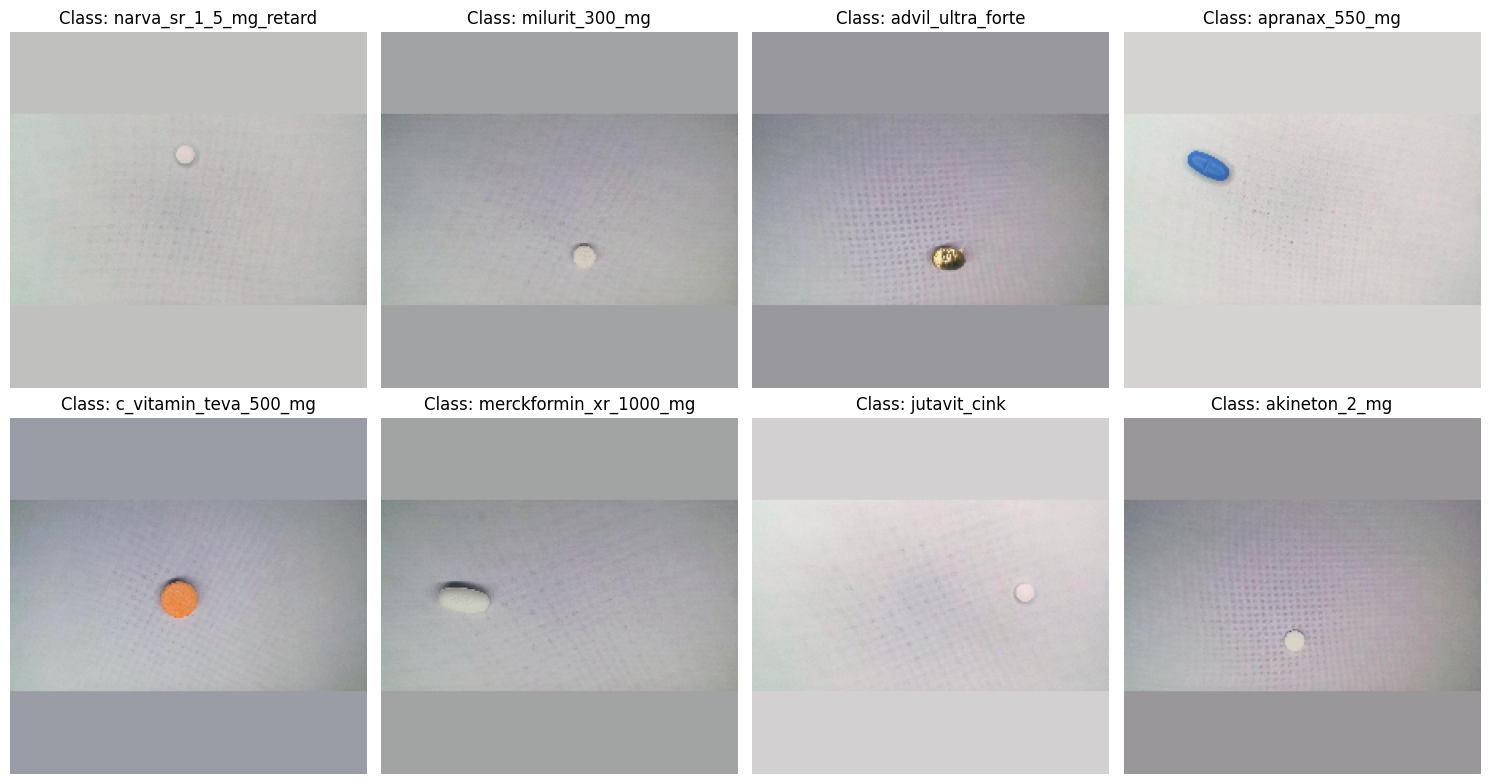

In [30]:

try:
    
    DATA_DIR = "./dataset/ogyeiv2"
    BATCH_SIZE = 32
    NUM_WORKERS = 0
    
    # Создаем DataLoader'ы
    print("🔄 Создание DataLoader'ов...")
    train_loader, val_loader, test_loader, class_to_idx = create_data_loaders(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        preprocess_fn=detect_and_crop_pill
    )
    
    print("✅ DataLoader'ы успешно созданы!")
    print(f"Количество классов: {len(class_to_idx)}")
    print(f"Размер батча: {BATCH_SIZE}")
    
    # Проверяем
    check_data_loaders(train_loader, val_loader, test_loader)
    
    # Визуализируем
    show_sample_images(train_loader, class_to_idx)
    
except FileNotFoundError as e:
    print(f"❌ Ошибка: Не найден путь к данным: {DATA_DIR}")
    print("Убедитесь, что путь указан правильно и датасет существует")
except Exception as e:
    print(f"❌ Произошла ошибка: {e}")

# Этап 2. Объявление модели

## mobilenet_v3_small(weights='IMAGENET1K_V1')

In [32]:
from torchsummary import summary
from torchvision.models import mobilenet_v3_small

model = mobilenet_v3_small(weights='IMAGENET1K_V1')

print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [44]:
# Замена слоев для классификации
#model.classifier = nn.Linear(in_features=576, out_features=84, bias=True)

model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=256, bias=True),
    nn.Hardswish(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=256, out_features=84, bias=True)  # 84 класса
)

# Заморозка слоёв модели
for param in model.parameters():
    param.requires_grad = False
# Разморозка полносвязного слоя classifier
for param in model.classifier.parameters():
    param.requires_grad = True    
# Проверка
summary(model, input_size=(3, 224, 224), device='cpu') 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

# Этап 3. Дообучение модели

In [49]:

# Настройка гиперпараметров
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10
best_vloss = 1e5


# Код обучения для одной эпохи
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for batch_index, data in enumerate(train_loader):
        # Извлечение батча
        inputs, labels = data
        # Обнуление градиентов
        optimizer.zero_grad()
        # Прямое распространение
        outputs = model(inputs)
        # Подсчёт ошибки
        loss = criterion(outputs, labels)
        # Обратное распространение
        loss.backward()
        # Обновление весов
        optimizer.step()

        # Суммирование ошибки за последние 20 батчей
        running_loss += loss.item()
        if batch_index % 20 == 19:
            last_loss = running_loss / 20. # средняя ошибка за 20 батчей
            print(f'Эпоха: {epoch_index}, батч: {batch_index}, ошибка {last_loss}')
            running_loss = 0.

    return last_loss


for epoch in range(EPOCHS):
    print(f'Эпоха {epoch}')

    #Перевод модели в режим обучения
    model.train(True)
    # Эпоха обучения
    avg_loss = train_one_epoch(epoch)

    # Перевод модели в режим валидации
    model.eval()
    running_vloss = 0.0

    # Валидация
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    # Сохранение лучшей модели
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'./models/meds_classifier_{epoch}.pt'
        torch.save(model.state_dict(), model_path)

    print(f'В конце эпохи ошибка train {avg_loss}, ошибка val {avg_vloss}') 

Эпоха 0
Эпоха: 0, батч: 19, ошибка 1.5122649729251862
Эпоха: 0, батч: 39, ошибка 1.362339401245117
В конце эпохи ошибка train 1.362339401245117, ошибка val 1.2676271200180054
Эпоха 1
Эпоха: 1, батч: 19, ошибка 1.2122540503740311
Эпоха: 1, батч: 39, ошибка 1.1478620439767837
В конце эпохи ошибка train 1.1478620439767837, ошибка val 1.101692795753479
Эпоха 2
Эпоха: 2, батч: 19, ошибка 1.1101494967937469
Эпоха: 2, батч: 39, ошибка 1.0142576307058335
В конце эпохи ошибка train 1.0142576307058335, ошибка val 0.998418390750885
Эпоха 3
Эпоха: 3, батч: 19, ошибка 0.9465298354625702
Эпоха: 3, батч: 39, ошибка 0.964962175488472
В конце эпохи ошибка train 0.964962175488472, ошибка val 0.8324374556541443
Эпоха 4
Эпоха: 4, батч: 19, ошибка 0.8564414829015732
Эпоха: 4, батч: 39, ошибка 0.8559925734996796
В конце эпохи ошибка train 0.8559925734996796, ошибка val 0.8122309446334839
Эпоха 5
Эпоха: 5, батч: 19, ошибка 0.6830090716481209
Эпоха: 5, батч: 39, ошибка 0.7645155414938927
В конце эпохи ошибка 

# Этап 4. Оценка качества

In [50]:
from sklearn.metrics import classification_report
labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels = data

        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # argmax по всем примерам
        labels_predicted.extend(predicted.numpy())
        labels_true.extend(labels.numpy())

print(classification_report(labels_true, labels_predicted, target_names=class_to_idx)) 

                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       1.00      1.00      1.00         6
                   akineton_2_mg       1.00      1.00      1.00         8
      algoflex_forte_dolo_400_mg       1.00      1.00      1.00         5
           algoflex_rapid_400_mg       1.00      1.00      1.00         5
                algopyrin_500_mg       1.00      1.00      1.00         8
             ambroxol_egis_30_mg       1.00      1.00      1.00         4
                  apranax_550_mg       1.00      1.00      1.00         4
            aspirin_ultra_500_mg       0.71      0.83      0.77         6
                    atoris_20_mg       1.00      1.00      1.00         3
         atorvastatin_teva_20_mg       1.00      0.22      0.36         9
                   betaloc_50_mg       1.00      1.00      1.00         6
                        bila_git     

In [51]:
from sklearn.metrics import classification_report
labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # argmax по всем примерам
        labels_predicted.extend(predicted.numpy())
        labels_true.extend(labels.numpy())

print(classification_report(labels_true, labels_predicted, target_names=class_to_idx)) 


                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       0.83      0.83      0.83         6
                   akineton_2_mg       1.00      0.83      0.91         6
      algoflex_forte_dolo_400_mg       1.00      1.00      1.00         6
           algoflex_rapid_400_mg       1.00      0.83      0.91         6
                algopyrin_500_mg       0.71      0.83      0.77         6
             ambroxol_egis_30_mg       1.00      1.00      1.00         6
                  apranax_550_mg       1.00      0.83      0.91         6
            aspirin_ultra_500_mg       0.57      0.67      0.62         6
                    atoris_20_mg       1.00      1.00      1.00         6
         atorvastatin_teva_20_mg       1.00      0.33      0.50         6
                   betaloc_50_mg       1.00      1.00      1.00         6
                        bila_git     

Общая accuracy для классификатора таблеток выше 75%

In [53]:
report = classification_report(labels_true, labels_predicted, 
                              target_names=list(class_to_idx.keys()), 
                              output_dict=True)
# Список precision по классам
precision_by_class = []
for class_name, metrics in report.items():
    if class_name in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    precision_by_class.append((class_name, metrics['precision']))

# Сортируем по precision (от низкого к высокому)
precision_by_class.sort(key=lambda x: x[1])

# Выводим 5 классов с самым низким precision
print("5 КЛАССОВ С САМЫМ НИЗКИМ PRECISION:")
print("=" * 50)
for i, (class_name, precision) in enumerate(precision_by_class[:5]):
    print(f"{i+1}. {class_name}: {precision:.4f}")

# Дополнительно: выводим полную таблицу для этих классов
print("\n" + "=" * 50)
print("ПОДРОБНАЯ ИНФОРМАЦИЯ ДЛЯ ЭТИХ КЛАССОВ:")
print("=" * 50)

for class_name, precision in precision_by_class[:5]:
    metrics = report[class_name]
    print(f"\n{class_name}:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-score:  {metrics['f1-score']:.4f}")
    print(f"  Support:   {metrics['support']}")


5 КЛАССОВ С САМЫМ НИЗКИМ PRECISION:
1. teva_ambrobene_30_mg: 0.4545
2. enterol_250_mg: 0.5455
3. nolpaza_20_mg: 0.5556
4. sicor_10_mg: 0.5556
5. aspirin_ultra_500_mg: 0.5714

ПОДРОБНАЯ ИНФОРМАЦИЯ ДЛЯ ЭТИХ КЛАССОВ:

teva_ambrobene_30_mg:
  Precision: 0.4545
  Recall:    0.8333
  F1-score:  0.5882
  Support:   6.0

enterol_250_mg:
  Precision: 0.5455
  Recall:    1.0000
  F1-score:  0.7059
  Support:   6.0

nolpaza_20_mg:
  Precision: 0.5556
  Recall:    0.8333
  F1-score:  0.6667
  Support:   6.0

sicor_10_mg:
  Precision: 0.5556
  Recall:    0.8333
  F1-score:  0.6667
  Support:   6.0

aspirin_ultra_500_mg:
  Precision: 0.5714
  Recall:    0.6667
  F1-score:  0.6154
  Support:   6.0


Таблетки данных классов в большей степени "похожи" и, как вариант дальнейшего развития в данной модели, потребуется увеличивать количество параметров и глубину слоев в model.classifier. Также на этапе предобработки изображений поработать над тем, чтобы в результате ресайза потерять как можно меньше признаков (контуров и фактур)

In [54]:
# Сортируем по precision (от высокого к низкому)
precision_by_class.sort(key=lambda x: x[1], reverse=True)

# Выводим 5 классов с самым низким precision
print("5 КЛАССОВ С САМЫМ ВЫСОКИМ PRECISION:")
print("=" * 50)
for i, (class_name, precision) in enumerate(precision_by_class[:5]):
    print(f"{i+1}. {class_name}: {precision:.4f}")

# Дополнительно: выводим полную таблицу для этих классов
print("\n" + "=" * 50)
print("ПОДРОБНАЯ ИНФОРМАЦИЯ ДЛЯ ЭТИХ КЛАССОВ:")
print("=" * 50)

for class_name, precision in precision_by_class[:5]:
    metrics = report[class_name]
    print(f"\n{class_name}:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-score:  {metrics['f1-score']:.4f}")
    print(f"  Support:   {metrics['support']}")


5 КЛАССОВ С САМЫМ ВЫСОКИМ PRECISION:
1. acc_long_600_mg: 1.0000
2. akineton_2_mg: 1.0000
3. algoflex_forte_dolo_400_mg: 1.0000
4. algoflex_rapid_400_mg: 1.0000
5. ambroxol_egis_30_mg: 1.0000

ПОДРОБНАЯ ИНФОРМАЦИЯ ДЛЯ ЭТИХ КЛАССОВ:

acc_long_600_mg:
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000
  Support:   6.0

akineton_2_mg:
  Precision: 1.0000
  Recall:    0.8333
  F1-score:  0.9091
  Support:   6.0

algoflex_forte_dolo_400_mg:
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000
  Support:   6.0

algoflex_rapid_400_mg:
  Precision: 1.0000
  Recall:    0.8333
  F1-score:  0.9091
  Support:   6.0

ambroxol_egis_30_mg:
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000
  Support:   6.0


Таблетки данных классов в большей степени содержат уникальные признаки (форму, фактуру, цвет), и в рамках текущих настроек модели результативно классифицируются

дополнительные способы анализа качества и ошибок модели

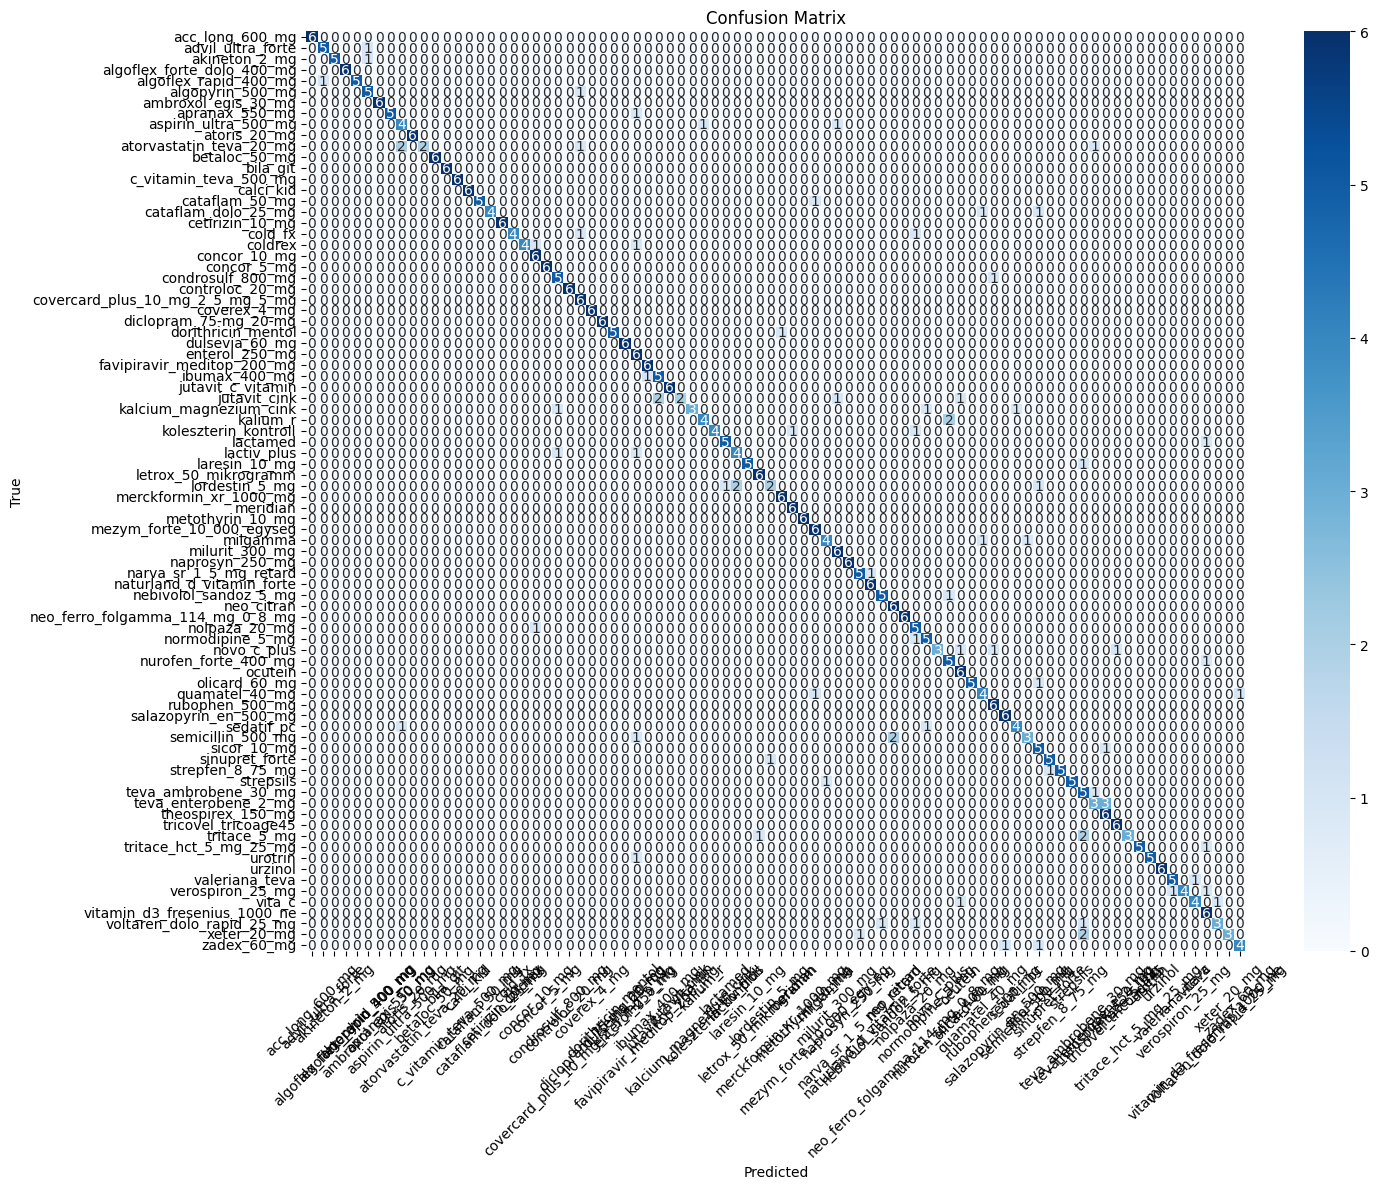


САМЫЕ ЧАСТЫЕ ОШИБКИ КЛАССИФИКАЦИИ:
teva_enterobene_2_mg → theospirex_150_mg: 3 ошибок
atorvastatin_teva_20_mg → aspirin_ultra_500_mg: 2 ошибок
jutavit_cink → ibumax_400_mg: 2 ошибок
kalium_r → nurofen_forte_400_mg: 2 ошибок
lordestin_5_mg → lactiv_plus: 2 ошибок
semicillin_500_mg → neo_citran: 2 ошибок
tritace_5_mg → teva_ambrobene_30_mg: 2 ошибок
xeter_20_mg → teva_ambrobene_30_mg: 2 ошибок
advil_ultra_forte → algopyrin_500_mg: 1 ошибок
akineton_2_mg → algopyrin_500_mg: 1 ошибок


In [55]:
# матрица ошибок (confusion matrix)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Создаем confusion matrix
cm = confusion_matrix(labels_true, labels_predicted)

# Визуализация
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_to_idx.keys()),
            yticklabels=list(class_to_idx.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Анализ самых частых ошибок
print("\nСАМЫЕ ЧАСТЫЕ ОШИБКИ КЛАССИФИКАЦИИ:")
print("=" * 50)
error_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            true_class = list(class_to_idx.keys())[i]
            pred_class = list(class_to_idx.keys())[j]
            error_pairs.append((true_class, pred_class, cm[i, j]))

# Сортируем по количеству ошибок
error_pairs.sort(key=lambda x: x[2], reverse=True)

for true_class, pred_class, count in error_pairs[:10]:
    print(f"{true_class} → {pred_class}: {count} ошибок")

In [57]:
# анализ по confidence score
confidences = []
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        max_probs, predicted = torch.max(probabilities, 1)
        
        confidences.extend(max_probs.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.numpy())

confidences = np.array(confidences)
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Анализ уверенности модели
correct_mask = (predictions == true_labels)
print(f"\nСРЕДНЯЯ УВЕРЕННОСТЬ:")
print(f"Правильные предсказания: {confidences[correct_mask].mean():.4f}")
print(f"Неправильные предсказания: {confidences[~correct_mask].mean():.4f}")

# Анализ калибровки модели
confidence_bins = np.linspace(0, 1, 11)
accuracy_bins = []

for i in range(len(confidence_bins) - 1):
    mask = (confidences >= confidence_bins[i]) & (confidences < confidence_bins[i + 1])
    if mask.sum() > 0:
        bin_accuracy = (predictions[mask] == true_labels[mask]).mean()
        accuracy_bins.append(bin_accuracy)
        print(f"Confidence [{confidence_bins[i]:.1f}-{confidence_bins[i+1]:.1f}]: "
              f"Accuracy = {bin_accuracy:.3f} ({mask.sum()} samples)")



СРЕДНЯЯ УВЕРЕННОСТЬ:
Правильные предсказания: 0.7760
Неправильные предсказания: 0.4836
Confidence [0.1-0.2]: Accuracy = 0.667 (3 samples)
Confidence [0.2-0.3]: Accuracy = 0.448 (29 samples)
Confidence [0.3-0.4]: Accuracy = 0.484 (31 samples)
Confidence [0.4-0.5]: Accuracy = 0.676 (34 samples)
Confidence [0.5-0.6]: Accuracy = 0.709 (55 samples)
Confidence [0.6-0.7]: Accuracy = 0.739 (46 samples)
Confidence [0.7-0.8]: Accuracy = 0.902 (61 samples)
Confidence [0.8-0.9]: Accuracy = 0.939 (82 samples)
Confidence [0.9-1.0]: Accuracy = 0.994 (163 samples)
